# Shared Experiment Analysis

Things this notebook does:

- Creates shared plots that look better and use shared legend
- Creates plot which shows average normalized performance across environments.

In [1]:
import copy
import os.path as osp
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import posggym_agents

import baposgmcp.plot as plot_utils
import baposgmcp.plot.paper as paper_utils
from baposgmcp.config import BASE_REPO_DIR

TINY_SIZE = 10
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TINY_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=TINY_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# For UAI paper formatting
PAGE_WIDTH = 6.75  # inches
PAGE_COL_WIDTH = (6.75 - 0.25) / 2

algname = "POTMMCP"
baselinealgname = "I-POMCP-PF"

BASE_EXP_DIR = osp.join(BASE_REPO_DIR, "experiments")
BASE_AGENT_DIR = osp.join(posggym_agents.config.BASE_DIR, 'agents')

ENVS = {
    "Driving14x14WideRoundAbout-n2-v0" : osp.join(
            BASE_AGENT_DIR, "driving14x14wideroundabout_n2_v0", "results", "klrbr_results.csv"
    ),        
    "PursuitEvasion16x16-v0": osp.join(
        BASE_AGENT_DIR, "pursuitevasion16x16_v0", "results", "pairwise_results.csv"
    ),
    "PredatorPrey10x10-P2-p3-s2-coop-v0": osp.join(
        BASE_AGENT_DIR, "predatorprey10x10_P2_p3_s2_coop_v0", "results", "pairwise_results.csv"
    ),
    "PredatorPrey10x10-P4-p3-s3-coop-v0": osp.join(
        BASE_AGENT_DIR, "predatorprey10x10_P4_p3_s3_coop_v0", "results", "pairwise_results.csv"
    )
}

sims_result_files = {
    env_id: osp.join(BASE_EXP_DIR, env_id, "results", "sims_expected_performance_results.csv")
    for env_id in ENVS
}
time_result_files = {
    env_id: osp.join(BASE_EXP_DIR, env_id, "results", "time_expected_performance_results.csv")
    for env_id in ENVS
}
pi_result_files = {
    env_id: osp.join(BASE_EXP_DIR, env_id, "results", "pi_expected_performance_results.csv")
    for env_id in ENVS
}

figure_dir = osp.join(BASE_EXP_DIR, "shared_figures")


env_labels = {
    "Driving14x14WideRoundAbout-n2-v0": "Driving",
    "PursuitEvasion16x16-v0": {
        0: "PE (Evader)",
        1: "PE (Pursuer)",
    },
    "PredatorPrey10x10-P2-p3-s2-coop-v0": "PP (two-agents)",
    "PredatorPrey10x10-P4-p3-s3-coop-v0": "PP (four-agents)",
}

print("Sim result files:")
for k, v in sims_result_files.items():
    print(" ", k, v)
    
print("\nTime result files:")
for k, v in time_result_files.items():
    print(" ", k, v)
    
print("\nPi result files:")
for k, v in pi_result_files.items():
    print(" ", k, v)

Sim result files:
  Driving14x14WideRoundAbout-n2-v0 /home/jonathon/code/ba-posgmcp/experiments/Driving14x14WideRoundAbout-n2-v0/results/sims_expected_performance_results.csv
  PursuitEvasion16x16-v0 /home/jonathon/code/ba-posgmcp/experiments/PursuitEvasion16x16-v0/results/sims_expected_performance_results.csv
  PredatorPrey10x10-P2-p3-s2-coop-v0 /home/jonathon/code/ba-posgmcp/experiments/PredatorPrey10x10-P2-p3-s2-coop-v0/results/sims_expected_performance_results.csv
  PredatorPrey10x10-P4-p3-s3-coop-v0 /home/jonathon/code/ba-posgmcp/experiments/PredatorPrey10x10-P4-p3-s3-coop-v0/results/sims_expected_performance_results.csv

Time result files:
  Driving14x14WideRoundAbout-n2-v0 /home/jonathon/code/ba-posgmcp/experiments/Driving14x14WideRoundAbout-n2-v0/results/time_expected_performance_results.csv
  PursuitEvasion16x16-v0 /home/jonathon/code/ba-posgmcp/experiments/PursuitEvasion16x16-v0/results/time_expected_performance_results.csv
  PredatorPrey10x10-P2-p3-s2-coop-v0 /home/jonathon/

## Load Results

In [2]:
sims_exp_dfs = {env_id: pd.read_csv(fpath) for env_id, fpath in sims_result_files.items()}
time_exp_dfs = {env_id: pd.read_csv(fpath) for env_id, fpath in time_result_files.items()}
pi_exp_dfs = {env_id: pd.read_csv(fpath) for env_id, fpath in pi_result_files.items()}

# helper functions
def get_df_info(df):
    alg_ids = df["alg_id"].unique().tolist()
    alg_ids.sort()
    print("Alg IDs")
    print("-------")
    for n in alg_ids:
        print(n)

    policy_ids = df["policy_id"].unique().tolist()
    policy_ids.sort()
    print("\nPolicy IDs")
    print("----------")
    for n in policy_ids:
        print(n)

        
def remove_agent_id(row):
    pi_id = row["policy_id"]
    tokens = pi_id.split("_")
    id_token = [t for t in tokens if t.startswith("i")][0]
    tokens.remove(id_token)
    return "_".join(tokens)


def add_standardized_return(row, return_means):
    n = row["search_time_limit"]
    return (row["episode_return_mean"] - return_means[n]) / row["episode_return_std"]


def add_standardized_CI(row):
    std = 1.0
    n = row["num_episodes"]
    return 1.96 * (std / np.sqrt(n))

# Meta-Policy Performance

In [3]:
meta_pi_label_map = {
    "greedy": r"$\sigma_{i}^{0}$",
    "softmax": r"$\sigma_{i}^{0.25}$",
    "uniform": r"$\sigma_{i}^{\infty}$",
}


def get_meta_pi_df(df):
    df = df[(df["alg_id"] == "baposgmcp") & (df["truncated"] == True)]
    
    search_times = df["search_time_limit"].unique().tolist()
    search_times.sort()
    
    return_means = {}
    for n in search_times:
        n_df = df[df["search_time_limit"] == n]
        return_means[n] = df["episode_return_mean"].mean()
    
    df["standardized_episode_return_mean"] = df.apply(
        lambda row: add_standardized_return(row, return_means), axis=1
    )
    df["standardized_episode_return_CI"] = df.apply(
        lambda row: add_standardized_CI(row), axis=1
    )
    return df


meta_pi_dfs = {}
for env_id, env_df in pi_exp_dfs.items():
    env_label = env_labels[env_id]
    print(env_id, env_label)
    if env_id == "PursuitEvasion16x16-v0":
        # Add seperate DFs for each agent
        for agent_id in env_df["agent_id"].unique():
            agent_df = env_df[env_df["agent_id"] == agent_id]
            agent_df["policy_id"] = agent_df.apply(remove_agent_id, axis=1)
            meta_pi_dfs[env_label[agent_id]] = get_meta_pi_df(agent_df)
    else:
        meta_pi_dfs[env_label] = get_meta_pi_df(env_df)

Driving14x14WideRoundAbout-n2-v0 Driving
PursuitEvasion16x16-v0 {0: 'PE (Evader)', 1: 'PE (Pursuer)'}
PredatorPrey10x10-P2-p3-s2-coop-v0 PP (two-agents)
PredatorPrey10x10-P4-p3-s3-coop-v0 PP (four-agents)


/tmp/ipykernel_301134/1815579516.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["standardized_episode_return_mean"] = df.apply(
/tmp/ipykernel_301134/1815579516.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["standardized_episode_return_CI"] = df.apply(
/tmp/ipykernel_301134/1815579516.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

## Meta-Policy Performance by environment

Performance of POTMMCP with each meta-policy, in each environment.

Driving
PE (Evader)
PE (Pursuer)
PP (two-agents)
PP (four-agents)


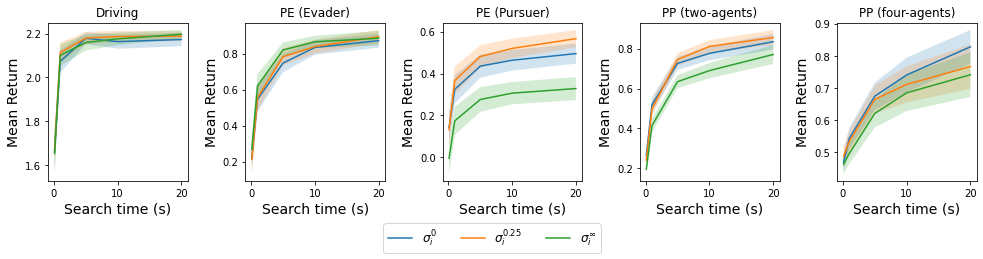

In [33]:
fig_kwargs = {"figsize": (PAGE_WIDTH*2, 3.5)}
subplot_kwargs = {
    "ylabel": "Mean Return",
    "xlabel": "Search time (s)"
}

num_rows = 1
num_cols = len(meta_pi_dfs)

fig, axs = plt.subplots(
    nrows=num_rows,
    ncols=num_cols,
    squeeze=False,
    subplot_kw=subplot_kwargs,
    **fig_kwargs,
)

for i, (env_label, env_df) in enumerate(meta_pi_dfs.items()):
    print(env_label)
    ax = axs[0][i]
    plot_utils.paper.plot_meta_policy_performance(
        env_df,
        ax=ax,
        x_key="search_time_limit",
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        meta_pi_label_map=meta_pi_label_map,
        alg_id_key="alg_id",
    )
    ax.set_title(env_label)
    
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=5, loc="lower center")

fig.tight_layout(pad=0.1, w_pad=0.8, h_pad=1.0, rect=(0.0, 0.16, 1.0, 1.0))
fig.savefig(osp.join(figure_dir, "shared_meta_pi_return.png"))

## Standardized Meta-Policy Performance

Performance of POTMMCP with each meta-policy, averaged across environments.

In [5]:
meta_pi_df = pd.concat(list(meta_pi_dfs.values()))
get_df_info(meta_pi_df)
    
agg_dict = plot_utils.get_uniform_expected_agg_map(meta_pi_df)
gb = meta_pi_df.groupby(["policy_id"])
gb_agg = gb.agg(**agg_dict)

print("\nUngrouped size =", len(meta_pi_df))
meta_pi_exp_df = gb_agg.reset_index()
print("Grouped size =", len(meta_pi_exp_df ))

new_policies = set(meta_pi_exp_df ["policy_id"].unique().tolist())
assert len(new_policies) == len(meta_pi_exp_df ), "Should be one row per policy ID"

Alg IDs
-------
baposgmcp

Policy IDs
----------
baposgmcp_metagreedy_searchtimelimit0.1_truncatedTrue
baposgmcp_metagreedy_searchtimelimit10_truncatedTrue
baposgmcp_metagreedy_searchtimelimit1_truncatedTrue
baposgmcp_metagreedy_searchtimelimit20_truncatedTrue
baposgmcp_metagreedy_searchtimelimit5_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit10_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit20_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit5_truncatedTrue
baposgmcp_metauniform_searchtimelimit0.1_truncatedTrue
baposgmcp_metauniform_searchtimelimit10_truncatedTrue
baposgmcp_metauniform_searchtimelimit1_truncatedTrue
baposgmcp_metauniform_searchtimelimit20_truncatedTrue
baposgmcp_metauniform_searchtimelimit5_truncatedTrue

Ungrouped size = 75
Grouped size = 15


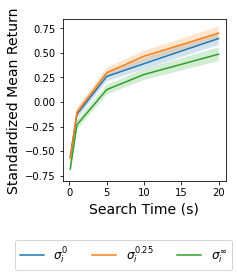

In [32]:
fig_kwargs = {"figsize": (PAGE_COL_WIDTH, 3.7)}
subplot_kwargs = {
    "ylabel": "Standardized Mean Return",
    "xlabel": "Search Time (s)"
}

num_rows = 1
num_cols = 1
fig, ax = plt.subplots(
    nrows=num_rows,
    ncols=num_cols,
    squeeze=True,
    subplot_kw=subplot_kwargs,
    **fig_kwargs,
)

plot_utils.paper.plot_meta_policy_performance(
    meta_pi_exp_df,
    ax,
    x_key="search_time_limit",
    y_key="standardized_episode_return_mean",
    y_err_key="standardized_episode_return_CI",
    meta_pi_label_map=meta_pi_label_map,
    alg_id_key="alg_id",
)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=3, loc="lower right")

fig.tight_layout(rect=(0.0, 0.18, 1.0, 1.0))
fig.savefig(osp.join(figure_dir, f"shared_meta_pi_standardize_return.png"))


# Meta vs fixed policy performance

In [7]:
meta_fixed_pi_label_map = {
    "Driving": {
        "baposgmcp_metasoftmax": r"$\sigma_{i}^{0.25}$",
        "baposgmcp-random": "Random",
        "baposgmcp-fixed_piklrk0seed0-v0": r"$\pi_{0}$", 
        "baposgmcp-fixed_piklrk1seed0-v0": r"$\pi_{1}$", 
        "baposgmcp-fixed_piklrk2seed0-v0": r"$\pi_{2}$",
        "baposgmcp-fixed_piklrk3seed0-v0": r"$\pi_{3}$",
        "baposgmcp-fixed_piklrk4seed0-v0": r"$\pi_{4}$",
    },
    "PE (Evader)": {
        "baposgmcp_metasoftmax": r"$\sigma_{i}^{0.25}$",
        "baposgmcp-random": "Random",
        "baposgmcp-fixed_piklrk0seed0i0-v0": r"$\pi_{0}$",
        "baposgmcp-fixed_piklrk1seed0i0-v0": r"$\pi_{1}$",
        "baposgmcp-fixed_piklrk2seed0i0-v0": r"$\pi_{2}$",
        "baposgmcp-fixed_piklrk3seed0i0-v0": r"$\pi_{3}$",
        "baposgmcp-fixed_piklrk4seed0i0-v0": r"$\pi_{4}$",
    },
    "PE (Pursuer)": {
        "baposgmcp_metasoftmax": r"$\sigma_{i}^{0.25}$",
        "baposgmcp-random": "Random",
        "baposgmcp-fixed_piklrk0seed0i1-v0": r"$\pi_{0}$",
        "baposgmcp-fixed_piklrk1seed0i1-v0": r"$\pi_{1}$",
        "baposgmcp-fixed_piklrk2seed0i1-v0": r"$\pi_{2}$",
        "baposgmcp-fixed_piklrk3seed0i1-v0": r"$\pi_{3}$",
        "baposgmcp-fixed_piklrk4seed0i1-v0": r"$\pi_{4}$",
    },
    "PP (two-agents)": {
        "baposgmcp_metasoftmax": r"$\sigma_{i}^{0.25}$",
        "baposgmcp-random": "Random",
        "baposgmcp-fixed_pispseed0-v0": r"$\pi_{0}$", 
        "baposgmcp-fixed_pispseed1-v0": r"$\pi_{1}$", 
        "baposgmcp-fixed_pispseed2-v0": r"$\pi_{2}$",
        "baposgmcp-fixed_pispseed3-v0": r"$\pi_{3}$",
        "baposgmcp-fixed_pispseed4-v0": r"$\pi_{4}$",
    }, 
    "PP (four-agents)": {
        "baposgmcp_metasoftmax": r"$\sigma_{i}^{0.25}$",
        "baposgmcp-random": "Random",
        "baposgmcp-fixed_pispseed0-v0": r"$\pi_{0}$", 
        "baposgmcp-fixed_pispseed1-v0": r"$\pi_{1}$", 
        "baposgmcp-fixed_pispseed2-v0": r"$\pi_{2}$",
        "baposgmcp-fixed_pispseed3-v0": r"$\pi_{3}$",
        "baposgmcp-fixed_pispseed4-v0": r"$\pi_{4}$",
    }
}

meta_fixed_pi_best_worst_label_map = {
    "Driving": {
        "baposgmcp_metasoftmax": r"$\sigma_{i}^{0.25}$",
        "baposgmcp-random": "Random",
        "baposgmcp-fixed_piklrk0seed0-v0": "Worst",  
        "baposgmcp-fixed_piklrk2seed0-v0": "Best",
    },
    "PE (Evader)": {
        "baposgmcp_metasoftmax": r"$\sigma_{i}^{0.25}$",
        "baposgmcp-random": "Random",
        "baposgmcp-fixed_piklrk0seed0i0-v0": "Worst",
        "baposgmcp-fixed_piklrk4seed0i0-v0": "Best",
    },
    "PE (Pursuer)": {
        "baposgmcp_metasoftmax": r"$\sigma_{i}^{0.25}$",
        "baposgmcp-random": "Random",
        "baposgmcp-fixed_piklrk0seed0i1-v0": "Worst",
        "baposgmcp-fixed_piklrk2seed0i1-v0": "Best",
    },
    "PP (two-agents)": {
        "baposgmcp_metasoftmax": r"$\sigma_{i}^{0.25}$",
        "baposgmcp-random": "Random",
        "baposgmcp-fixed_pispseed1-v0": "Worst",
        "baposgmcp-fixed_pispseed4-v0": "Best",
    }, 
    "PP (four-agents)": {
        "baposgmcp_metasoftmax": r"$\sigma_{i}^{0.25}$",
        "baposgmcp-random": "Random",
        "baposgmcp-fixed_pispseed0-v0": "Worst", 
        "baposgmcp-fixed_pispseed3-v0": "Best", 
    }
}

pi_group_label_map = {
    "baposgmcp_metasoftmax": r"$\sigma_{i}^{0.25}$",
    "baposgmcp-random": "Random",
    "baposgmcp-fixed_best": "Best",
    "baposgmcp-fixed_worst": "Worst",
}


def get_meta_fixed_df(df, env_label):
    pi_map = meta_fixed_pi_best_worst_label_map[env_label]
    best_fixed_pi_id_prefix = [k for k, v in pi_map.items() if v == "Best"][0]
    worst_fixed_pi_id_prefix = [k for k, v in pi_map.items() if v == "Worst"][0]
    
    df = df[
        ((df["alg_id"] == "baposgmcp") & (df["meta_pi"] == "softmax") & (df["truncated"] == True))
        | ((df["alg_id"] == "baposgmcp-fixed") & (df["truncated"] == True))
        | ((df["alg_id"] == "baposgmcp-random") & (df["truncated"] == False))
    ]
    
    def add_pi_group(row):
        pi_id = row["policy_id"]
        tokens = pi_id.split("_")
        if pi_id.startswith("baposgmcp-random"):
            group = pi_id
        elif pi_id.startswith("baposgmcp_meta"):
            group = pi_id
        elif pi_id.startswith(best_fixed_pi_id_prefix):
            tokens[1] = "best"
            group = "_".join(tokens)
        elif pi_id.startswith(worst_fixed_pi_id_prefix):
            tokens[1] = "worst"
            group = "_".join(tokens)
        else:
            tokens[1] = "other"
            group = "_".join(tokens)
        return group
            
    df["policy_group"] = df.apply(add_pi_group, axis=1)
    
    search_times = df["search_time_limit"].unique().tolist()
    search_times.sort()
    
    return_means = {}
    for n in search_times:
        n_df = df[df["search_time_limit"] == n]
        return_means[n] = df["episode_return_mean"].mean()
        
    pprint(return_means)
    print()
    policy_ids = df["policy_id"].unique().tolist()
    policy_ids.sort()
    for pi_id in policy_ids:
        pi_group = df[df["policy_id"] == pi_id]["policy_group"].unique().tolist()
        print(pi_id, pi_group)
    
    df["standardized_episode_return_mean"] = df.apply(
        lambda row: add_standardized_return(row, return_means), axis=1
    )
    df["standardized_episode_return_CI"] = df.apply(
        lambda row: add_standardized_CI(row), axis=1
    )
        
    return df
      
        
meta_fixed_dfs = {}
for env_id, env_df in pi_exp_dfs.items():
    env_label = env_labels[env_id]
    if env_id == "PursuitEvasion16x16-v0":
        # Add seperate DFs for each agent
        for agent_id in env_df["agent_id"].unique():
            agent_env_label = env_label[agent_id]
            print("\n", env_id, "-", agent_env_label)
            agent_df = env_df[env_df["agent_id"] == agent_id]
            agent_df["policy_id"] = agent_df.apply(remove_agent_id, axis=1)
            meta_fixed_dfs[agent_env_label] = get_meta_fixed_df(agent_df, agent_env_label)
    else:
        print("\n", env_id, "-", env_label)
        meta_fixed_dfs[env_label] = get_meta_fixed_df(env_df, env_label)


 Driving14x14WideRoundAbout-n2-v0 - Driving
{0.1: 1.9206512892216738,
 1.0: 1.9206512892216738,
 5.0: 1.9206512892216738,
 10.0: 1.9206512892216738,
 20.0: 1.9206512892216738}

baposgmcp-fixed_piklrk0seed0-v0_searchtimelimit0.1_truncatedTrue ['baposgmcp-fixed_worst_searchtimelimit0.1_truncatedTrue']
baposgmcp-fixed_piklrk0seed0-v0_searchtimelimit10_truncatedTrue ['baposgmcp-fixed_worst_searchtimelimit10_truncatedTrue']
baposgmcp-fixed_piklrk0seed0-v0_searchtimelimit1_truncatedTrue ['baposgmcp-fixed_worst_searchtimelimit1_truncatedTrue']
baposgmcp-fixed_piklrk0seed0-v0_searchtimelimit20_truncatedTrue ['baposgmcp-fixed_worst_searchtimelimit20_truncatedTrue']
baposgmcp-fixed_piklrk0seed0-v0_searchtimelimit5_truncatedTrue ['baposgmcp-fixed_worst_searchtimelimit5_truncatedTrue']
baposgmcp-fixed_piklrk1seed0-v0_searchtimelimit0.1_truncatedTrue ['baposgmcp-fixed_other_searchtimelimit0.1_truncatedTrue']
baposgmcp-fixed_piklrk1seed0-v0_searchtimelimit10_truncatedTrue ['baposgmcp-fixed_other_se

/tmp/ipykernel_301134/2298413731.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["policy_group"] = df.apply(add_pi_group, axis=1)
/tmp/ipykernel_301134/2298413731.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["standardized_episode_return_mean"] = df.apply(
/tmp/ipykernel_301134/2298413731.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/


 PredatorPrey10x10-P2-p3-s2-coop-v0 - PP (two-agents)
{0.1: 0.48806841440591037,
 1.0: 0.48806841440591037,
 5.0: 0.48806841440591037,
 10.0: 0.48806841440591037,
 20.0: 0.48806841440591037}

baposgmcp-fixed_pispseed0-v0_searchtimelimit0.1_truncatedTrue ['baposgmcp-fixed_other_searchtimelimit0.1_truncatedTrue']
baposgmcp-fixed_pispseed0-v0_searchtimelimit10_truncatedTrue ['baposgmcp-fixed_other_searchtimelimit10_truncatedTrue']
baposgmcp-fixed_pispseed0-v0_searchtimelimit1_truncatedTrue ['baposgmcp-fixed_other_searchtimelimit1_truncatedTrue']
baposgmcp-fixed_pispseed0-v0_searchtimelimit20_truncatedTrue ['baposgmcp-fixed_other_searchtimelimit20_truncatedTrue']
baposgmcp-fixed_pispseed0-v0_searchtimelimit5_truncatedTrue ['baposgmcp-fixed_other_searchtimelimit5_truncatedTrue']
baposgmcp-fixed_pispseed1-v0_searchtimelimit0.1_truncatedTrue ['baposgmcp-fixed_worst_searchtimelimit0.1_truncatedTrue']
baposgmcp-fixed_pispseed1-v0_searchtimelimit10_truncatedTrue ['baposgmcp-fixed_worst_searchti

/tmp/ipykernel_301134/2298413731.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["policy_group"] = df.apply(add_pi_group, axis=1)
/tmp/ipykernel_301134/2298413731.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["standardized_episode_return_mean"] = df.apply(
/tmp/ipykernel_301134/2298413731.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

## Meta vs Fixed policy Performance by environment

Performance of POTMMCP with softmax meta-policy, random policy, and the fixed policies, in each environment.

Driving
PE (Evader)
PE (Pursuer)
PP (two-agents)
PP (four-agents)
Driving
PE (Evader)
PE (Pursuer)
PP (two-agents)
PP (four-agents)


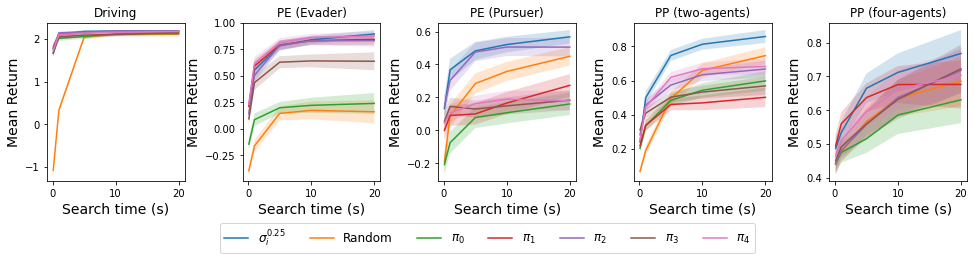

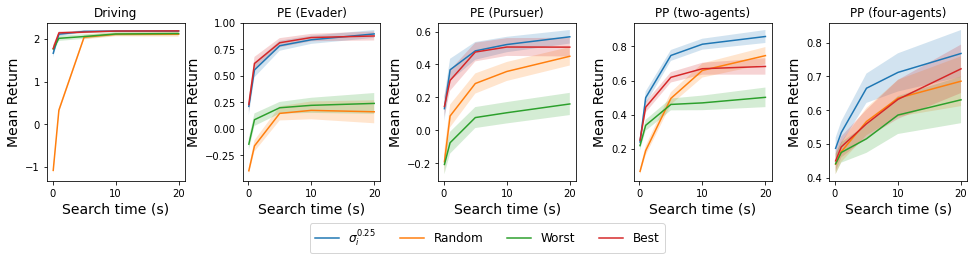

In [31]:
fig_kwargs = {"figsize": (PAGE_WIDTH*2, 3.5)}
subplot_kwargs = {
    "ylabel": "Mean Return",
    "xlabel": "Search time (s)"
}

num_rows = 1
num_cols = len(meta_fixed_dfs)

for env_pi_label_map, fig_label in [
    (meta_fixed_pi_label_map, "shared_meta_vs_all_fixed_pi_return.png"),
    (meta_fixed_pi_best_worst_label_map, "shared_meta_vs_best_worst_fixed_pi_return.png")
]:
    fig, axs = plt.subplots(
        nrows=num_rows,
        ncols=num_cols,
        squeeze=False,
        subplot_kw=subplot_kwargs,
        **fig_kwargs,
    )

    for i, (env_label, env_df) in enumerate(meta_fixed_dfs.items()):
        print(env_label)
        env_pi_labels = env_pi_label_map[env_label]
        ax = axs[0][i]
        plot_utils.paper.plot_performance(
            env_df,
            ax=ax,
            x_key="search_time_limit",
            y_key="episode_return_mean",
            y_err_key="episode_return_CI",
            policy_prefixes=list(env_pi_labels),
            pi_label_map=env_pi_labels,
            constant_policy_prefixes=[],
            policy_key="policy_id",
        )
        ax.set_title(env_label)

    handles, labels = axs[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, ncol=7, loc="lower center")

    fig.tight_layout(pad=0.1, w_pad=0.8, h_pad=1.0, rect=(0.0, 0.16, 1.0, 1.0))
    fig.savefig(osp.join(figure_dir, fig_label))

## Standardized Meta-policy vs fixed policy performance

In [9]:
concated_meta_fixed_df = pd.concat(list(meta_fixed_dfs.values()))
get_df_info(concated_meta_fixed_df)
    
agg_dict = plot_utils.get_uniform_expected_agg_map(concated_meta_fixed_df)
for k in ["policy_group"]:
    if k in agg_dict:
        del agg_dict[k]

gb = concated_meta_fixed_df.groupby(["policy_group"])
gb_agg = gb.agg(**agg_dict)

print("\nUngrouped size =", len(concated_meta_fixed_df))
averaged_meta_fixed_df = gb_agg.reset_index()
print("Grouped size =", len(averaged_meta_fixed_df ))

print()
new_policy_groups = averaged_meta_fixed_df["policy_group"].unique().tolist()
new_policy_groups.sort()
for pi_gp in new_policy_groups:
    print(pi_gp)
    
assert len(new_policy_groups) == len(averaged_meta_fixed_df)


Alg IDs
-------
baposgmcp
baposgmcp-fixed
baposgmcp-random

Policy IDs
----------
baposgmcp-fixed_piklrk0seed0-v0_searchtimelimit0.1_truncatedTrue
baposgmcp-fixed_piklrk0seed0-v0_searchtimelimit10_truncatedTrue
baposgmcp-fixed_piklrk0seed0-v0_searchtimelimit1_truncatedTrue
baposgmcp-fixed_piklrk0seed0-v0_searchtimelimit20_truncatedTrue
baposgmcp-fixed_piklrk0seed0-v0_searchtimelimit5_truncatedTrue
baposgmcp-fixed_piklrk0seed0i0-v0_searchtimelimit0.1_truncatedTrue
baposgmcp-fixed_piklrk0seed0i0-v0_searchtimelimit10_truncatedTrue
baposgmcp-fixed_piklrk0seed0i0-v0_searchtimelimit1_truncatedTrue
baposgmcp-fixed_piklrk0seed0i0-v0_searchtimelimit20_truncatedTrue
baposgmcp-fixed_piklrk0seed0i0-v0_searchtimelimit5_truncatedTrue
baposgmcp-fixed_piklrk0seed0i1-v0_searchtimelimit0.1_truncatedTrue
baposgmcp-fixed_piklrk0seed0i1-v0_searchtimelimit10_truncatedTrue
baposgmcp-fixed_piklrk0seed0i1-v0_searchtimelimit1_truncatedTrue
baposgmcp-fixed_piklrk0seed0i1-v0_searchtimelimit20_truncatedTrue
baposg

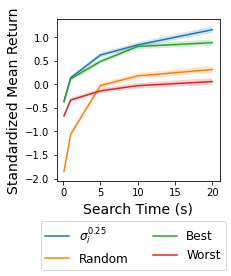

In [30]:
fig_kwargs = {"figsize": (PAGE_COL_WIDTH, 3.7)}
subplot_kwargs = {
    "ylabel": "Standardized Mean Return",
    "xlabel": "Search Time (s)"
}

num_rows = 1
num_cols = 1
fig, ax = plt.subplots(
    nrows=num_rows,
    ncols=num_cols,
    squeeze=True,
    subplot_kw=subplot_kwargs,
    **fig_kwargs,
)

plot_utils.paper.plot_performance(
    averaged_meta_fixed_df,
    ax,
    x_key="search_time_limit",
    y_key="standardized_episode_return_mean",
    y_err_key="standardized_episode_return_CI",
    policy_prefixes=list(pi_group_label_map),
    pi_label_map=pi_group_label_map,
    constant_policy_prefixes=[],
    policy_key="policy_group",
)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, loc="lower right")

fig.tight_layout(rect=(0.0, 0.18, 1.0, 1.0))
fig.savefig(osp.join(figure_dir, f"shared_meta_fixed_standardize_return.png"))

# Baseline performance vs search time

In [11]:
time_baseline_dfs = {}
for env_id, fpath in time_result_files.items():
    env_df = pd.read_csv(fpath)
    env_label = env_labels[env_id]
    print(env_id)
    if env_id == "PursuitEvasion16x16-v0":
        # Add seperate DFs for each agent
        for agent_id in env_df["agent_id"].unique():
            agent_df = env_df[env_df["agent_id"] == agent_id]
            agent_df["policy_id"] = agent_df.apply(remove_agent_id, axis=1)
            time_baseline_dfs[env_label[agent_id]] = agent_df
    else:
        time_baseline_dfs[env_label] = env_df

for env_label, env_df in time_baseline_dfs.items():
    print("\n##########")
    print(env_label)
    print("##########")
    get_df_info(env_df)

Driving14x14WideRoundAbout-n2-v0
PursuitEvasion16x16-v0
PredatorPrey10x10-P2-p3-s2-coop-v0
PredatorPrey10x10-P4-p3-s3-coop-v0

##########
Driving
##########
Alg IDs
-------
baposgmcp
baposgmcp-random
fixed
full-knowledge-br
metabaseline
ucbmcp
ucbmcp-random

Policy IDs
----------
baposgmcp-random_searchtimelimit0.1_truncatedFalse
baposgmcp-random_searchtimelimit10_truncatedFalse
baposgmcp-random_searchtimelimit1_truncatedFalse
baposgmcp-random_searchtimelimit20_truncatedFalse
baposgmcp-random_searchtimelimit5_truncatedFalse
baposgmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit10_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit20_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit5_truncatedTrue
full-knowledge-br
klr_k0_seed0-v0
klr_k1_seed0-v0
klr_k2_seed0-v0
klr_k3_seed0-v0
klr_k4_seed0-v0
metabaseline_softmax
ucbmcp-random_searchtimelimit0.1_truncatedFalse
ucbmcp-random_searchtimelimit10_tr

/tmp/ipykernel_301134/1221597336.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agent_df["policy_id"] = agent_df.apply(remove_agent_id, axis=1)
/tmp/ipykernel_301134/1221597336.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agent_df["policy_id"] = agent_df.apply(remove_agent_id, axis=1)


Driving
PE (Evader)
PE (Pursuer)
PP (two-agents)
PP (four-agents)


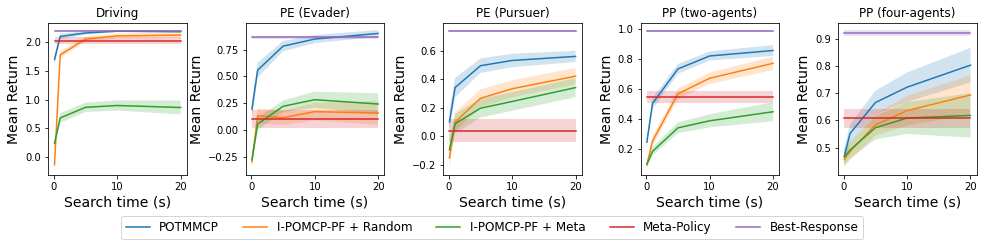

In [28]:
best_meta_pi = "softmax"

time_baseline_policy_prefixes_to_plot = [
    f"baposgmcp_meta{best_meta_pi}",
    # "baposgmcp-random",
    "ucbmcp-random",
    f"ucbmcp_meta{best_meta_pi}",
    f"metabaseline_{best_meta_pi}",
    f"full-knowledge-br",   
]
constant_policy_prefixes = [
    f"metabaseline_{best_meta_pi}",
    f"full-knowledge-br",
]

time_baseline_pi_label_map = {
    f"baposgmcp_meta{best_meta_pi}": algname,
    # "baposgmcp-random": f"{algname} + Random", 
    "full-knowledge-br": "Best-Response",
    f"metabaseline_{best_meta_pi}": "Meta-Policy",
    f"ucbmcp_meta{best_meta_pi}": f"{baselinealgname} + Meta",
    "ucbmcp-random": f"{baselinealgname} + Random"
}

fig_kwargs = {"figsize": (PAGE_WIDTH*2, 3.3)}
subplot_kwargs = {
    "ylabel": "Mean Return",
    "xlabel": "Search time (s)"
}


num_rows = 1
num_cols = len(time_baseline_dfs)

fig, axs = plt.subplots(
    nrows=num_rows,
    ncols=num_cols,
    squeeze=False,
    subplot_kw=subplot_kwargs,
    **fig_kwargs,
)

for i, (env_label, env_df) in enumerate(time_baseline_dfs.items()):
    print(env_label)
    ax = axs[0][i]
    plot_utils.paper.plot_performance(
        env_df,
        ax=ax,
        x_key="search_time_limit",
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        policy_key="policy_id",
        policy_prefixes=time_baseline_policy_prefixes_to_plot,
        constant_policy_prefixes=constant_policy_prefixes,
        pi_label_map=time_baseline_pi_label_map,
    )
    ax.set_title(env_label)
    
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=5, loc="lower center")

fig.tight_layout(pad=0.1, w_pad=0.9, h_pad=1.0, rect=(0.0, 0.14, 1.0, 1.0))
fig.savefig(osp.join(figure_dir, "shared_baselines_return_vs_search_time.png"))

# Search Depth

In [13]:
baseline_pi_label_map = {
    f"baposgmcp_meta{best_meta_pi}": algname,
    # f"baposgmcp-random": f"{algname} + Random",
    f"ucbmcp_meta{best_meta_pi}": f"{baselinealgname} + Meta",
    "ucbmcp-random": f"{baselinealgname} + Random"
}


time_avg_dfs = []
for env_label, env_df in time_baseline_dfs.items():
    print(env_label)
    sub_df = env_df[
        ((env_df["alg_id"] == "baposgmcp") & (env_df["meta_pi"] == "softmax") & (env_df["truncated"] == True))
        | ((env_df["alg_id"] == "baposgmcp-random") & (env_df["truncated"] == False))
        | ((env_df["alg_id"] == "ucbmcp") & (env_df["meta_pi"] == "softmax") & (env_df["truncated"] == True))
        | ((env_df["alg_id"] == "ucbmcp-random") & (env_df["truncated"] == False))
    ]
    time_avg_dfs.append(sub_df)

time_avg_df = pd.concat(time_avg_dfs)
print()
get_df_info(time_avg_df)
    
agg_dict = plot_utils.get_uniform_expected_agg_map(time_avg_df)
gb = time_avg_df.groupby(["policy_id"])
gb_agg = gb.agg(**agg_dict)

print("\nUngrouped size =", len(time_avg_df))
time_avg_exp_df = gb_agg.reset_index()
print("Grouped size =", len(time_avg_exp_df ))

new_policies = set(time_avg_exp_df ["policy_id"].unique().tolist())
assert len(new_policies) == len(time_avg_exp_df), "Should be one row per policy ID"

Driving
PE (Evader)
PE (Pursuer)
PP (two-agents)
PP (four-agents)

Alg IDs
-------
baposgmcp
baposgmcp-random
ucbmcp
ucbmcp-random

Policy IDs
----------
baposgmcp-random_searchtimelimit0.1_truncatedFalse
baposgmcp-random_searchtimelimit10_truncatedFalse
baposgmcp-random_searchtimelimit1_truncatedFalse
baposgmcp-random_searchtimelimit20_truncatedFalse
baposgmcp-random_searchtimelimit5_truncatedFalse
baposgmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit10_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit20_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit5_truncatedTrue
ucbmcp-random_searchtimelimit0.1_truncatedFalse
ucbmcp-random_searchtimelimit10_truncatedFalse
ucbmcp-random_searchtimelimit1_truncatedFalse
ucbmcp-random_searchtimelimit20_truncatedFalse
ucbmcp-random_searchtimelimit5_truncatedFalse
ucbmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
ucbmcp_metasoftmax_searchtimelimit10_trunc

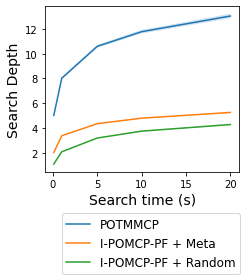

In [14]:
best_meta_pi = "softmax"

fig_kwargs = {"figsize": (PAGE_COL_WIDTH, 3.8)}
subplot_kwargs = {
    "ylabel": "Search Depth",
    "xlabel": "Search time (s)"
}

num_rows = 1
num_cols = 1

fig, ax = plt.subplots(
    nrows=num_rows,
    ncols=num_cols,
    squeeze=True,
    subplot_kw=subplot_kwargs,
    **fig_kwargs,
)

plot_utils.paper.plot_performance(
    time_avg_exp_df,
    ax=ax,
    x_key="search_time_limit",
    y_key="search_depth_mean",
    y_err_key="search_depth_CI",
    policy_key="policy_id",
    policy_prefixes=list(baseline_pi_label_map),
    constant_policy_prefixes=[],
    pi_label_map=baseline_pi_label_map,
)
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=1, loc="lower right")

fig.tight_layout(pad=0.1, w_pad=0.8, h_pad=1.0, rect=(0.0, 0.26, 1.0, 1.0))
fig.savefig(osp.join(figure_dir, "shared_search_depth_vs_search_time.png"))

del fig_kwargs
del subplot_kwargs

# Belief Accuracy

In [15]:
belief_dfs = {}
for env_label, env_df in time_baseline_dfs.items():
    belief_dfs[env_label] = env_df[
        (env_df["alg_id"] == "baposgmcp") & (env_df["meta_pi"] == "softmax") & (env_df["truncated"] == True)
    ]

for env_label, env_df in belief_dfs.items():
    print("\n##########")
    print(env_label)
    print("##########")
    get_df_info(env_df)


##########
Driving
##########
Alg IDs
-------
baposgmcp

Policy IDs
----------
baposgmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit10_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit20_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit5_truncatedTrue

##########
PE (Evader)
##########
Alg IDs
-------
baposgmcp

Policy IDs
----------
baposgmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit10_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit20_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit5_truncatedTrue

##########
PE (Pursuer)
##########
Alg IDs
-------
baposgmcp

Policy IDs
----------
baposgmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit10_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit20_truncatedTr

In [16]:
for env_label, env_df in belief_dfs.items():
    print(f"\n{env_label}")
    sts = env_df["search_time_limit"].unique().tolist()
    sts.sort()
    for st in sts:
        print(st, "-", env_df[env_df["search_time_limit"] == st]["episode_steps_mean"].tolist())


Driving
0.1 - [23.565625]
1.0 - [20.620625]
5.0 - [20.48]
10.0 - [20.91375]
20.0 - [20.937901145435895]

PE (Evader)
0.1 - [23.704375]
1.0 - [27.945625]
5.0 - [32.366875]
10.0 - [32.54038043478261]
20.0 - [33.11045511451184]

PE (Pursuer)
0.1 - [24.47]
1.0 - [18.4325]
5.0 - [15.546875]
10.0 - [14.775]
20.0 - [13.65713028169014]

PP (two-agents)
0.1 - [48.846]
1.0 - [45.163]
5.0 - [39.778]
10.0 - [37.90069607133403]
20.0 - [36.83365963922764]

PP (four-agents)
0.1 - [47.972]
1.0 - [46.785]
5.0 - [44.195396366423694]
10.0 - [42.67211400667343]
20.0 - [40.81678423163523]


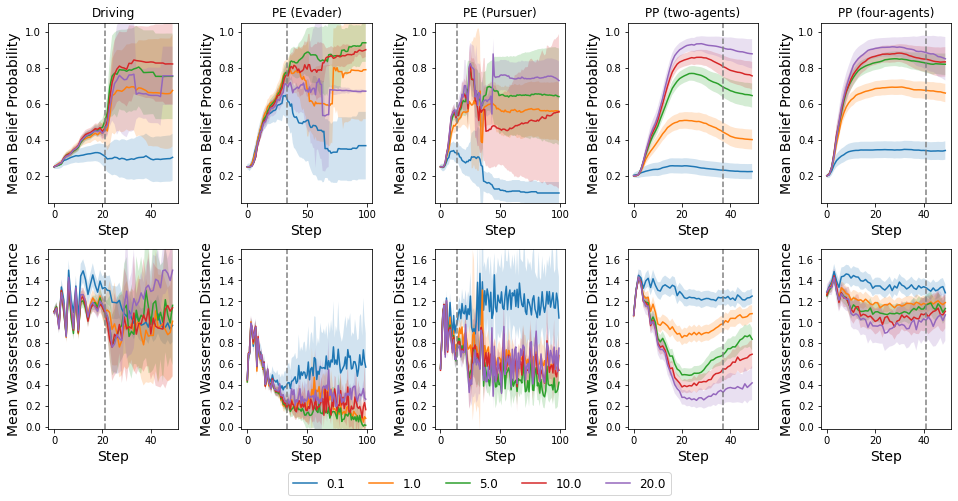

In [17]:
fig_kwargs = {"figsize": (PAGE_WIDTH*2, 7)}
subplot_kwargs = {
    "xlabel": "Step"
}

num_rows = 2
num_cols = len(belief_dfs)
fig, axs = plt.subplots(
    nrows=num_rows,
    ncols=num_cols,
    squeeze=False,
    subplot_kw=subplot_kwargs,
    **fig_kwargs,
)

y_lims = [(0.05, 1.05), (-0.02, 1.7)]
y_labels = ["Mean Belief Probability", "Mean Wasserstein Distance"]
env_step_limits = {
    "Driving": 50,
    "PE (Evader)": 100,
    "PE (Pursuer)": 100,
    "PP (two-agents)": 50,
    "PP (four-agents)": 50,
}
env_other_agent_id = {
    "Driving": 1,
    "PE (Evader)": 1,
    "PE (Pursuer)": 0,
    "PP (two-agents)": 1,
    "PP (four-agents)": 1,
}
# mean steps taken for POTMMCP with 20.0 seconds planning time
env_mean_steps = {
    "Driving": 20.94,
    "PE (Evader)": 33.11,
    "PE (Pursuer)": 13.66,
    "PP (two-agents)": 36.83,
    "PP (four-agents)": 40.82,
}


for i, (env_label, env_df) in enumerate(belief_dfs.items()):
    plot_utils.paper.plot_expected_belief_stat_by_step(
        env_df,
        axs[0][i],
        z_key="search_time_limit",
        y_key_prefix="bayes_accuracy",
        step_limit=env_step_limits[env_label],
        other_agent_id=env_other_agent_id[env_label],
        y_suffix="mean",
        y_err_suffix="CI",
    )
    axs[0][i].set_ylabel(y_labels[0])
    axs[0][i].set_ylim(y_lims[0])

    plot_utils.paper.plot_expected_belief_stat_by_step(
        env_df,
        axs[1][i],
        z_key="search_time_limit",
        y_key_prefix="action_dist_distance",
        step_limit=env_step_limits[env_label],
        other_agent_id=env_other_agent_id[env_label],
        y_suffix="mean",
        y_err_suffix="CI",
    )
    axs[1][i].set_ylabel(y_labels[1])
    axs[1][i].set_ylim(y_lims[1])
    axs[0][i].set_title(env_label)
    
    axs[0][i].axvline(env_mean_steps[env_label], linestyle="--", color="grey")
    axs[1][i].axvline(env_mean_steps[env_label], linestyle="--", color='grey')

handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=5, loc="lower center")

fig.tight_layout(rect=(0.0, 0.05, 1.0, 1.0))
fig.savefig(osp.join(figure_dir, f"shared_bayes_accuracy.png"))
    
del fig_kwargs
del subplot_kwargs

# Environment diagrams

In [18]:
import posggym

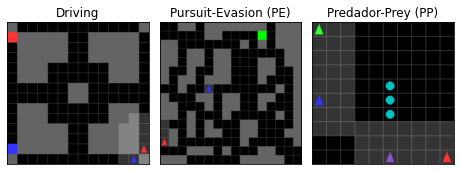

In [19]:
def plot_environment(env_id: str, ax):
    # Turn off x/y axis numbering/ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    env = posggym.make(env_id)
    env_img = env.render(mode='rgb_array')

    if isinstance(env_img, tuple):
        # render returns img for each agent
        # env img is 0th by default
        env_img = env_img[0]

    imshow_obj = ax.imshow(
        env_img, interpolation='bilinear', origin='upper'
    )
    imshow_obj.set_data(env_img)
    env.close()
    return ax

fig_kwargs = {"figsize": (PAGE_COL_WIDTH*2, 2.35)}
subplot_kwargs = {}

env_ids_to_plot = {
    "Driving14x14WideRoundAbout-n2-v0": "Driving",
    "PursuitEvasion16x16-v0": "Pursuit-Evasion (PE)",
    # "PredatorPrey10x10-P2-p3-s2-coop-v0": "PP (two-agents)",
    "PredatorPrey10x10-P4-p3-s3-coop-v0": "Predador-Prey (PP)",
}

num_rows = 1
num_cols = len(env_ids_to_plot)
fig, axs = plt.subplots(
    nrows=num_rows,
    ncols=num_cols,
    squeeze=False,
    subplot_kw=subplot_kwargs,
    **fig_kwargs,
)

for i, (env_id, env_label) in enumerate(env_ids_to_plot.items()):
    ax = axs[0][i]
    plot_environment(env_id, ax)
    ax.set_title(env_label)
    
fig.tight_layout(rect=(0.0, 0.00, 1.0, 1.0))
fig.savefig(osp.join(figure_dir, f"envs.png"))
    
del fig_kwargs
del subplot_kwargs